# Installations

In [ ]:
pip install sklearn numpy pandas matplotlib seaborn scikit-learn yellowbrick

# Imports

In [35]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

# Loading the Dataset

In [36]:
#Loading the dataset
df = pd.read_csv("D:\Projects\Clustering\marketing_campaign.csv", sep="\t")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [37]:
df.shape

(2240, 29)

# EDA and Data Cleaning

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### Dealing with Missing values

In [39]:
# Check for missing values
missing = df.isna().sum().sum()
if missing > 0:
    for col in df.columns:
        miss = df[col].isna().sum()
        if miss > 0:
            print("{0} has {1} msising values".format(col, miss))
else:
    print("No missing values")

Income has 24 msising values


In [40]:
# Removing the NA values
df = df.dropna()
print("The Shape of DataFrame after removing the rows with missing values are:", df.shape)

The Shape of DataFrame after removing the rows with missing values are: (2216, 29)


### Cleaning Dt_Customer column

In [41]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))


The newest customer's enrolment date in therecords: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


Creating a feature **("Customer_For")** of the number of days the customers started to shop in the store relative to the last recorded date

In [42]:
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
df["Customer_For"] = days
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="coerce")

### Feature Engineering

- Extract the **"Age"** of a customer by the **"Year_Birth"** indicating the birth year of the respective person.
- Create another feature **"Spent"** indicating the total amount spent by the customer in various categories over the span of two years.
- Create another feature **"Living_With"** out of **"Marital_Status"** to extract the living situation of couples.
- Create a feature **"Children"** to indicate total children in a household that is, kids and teenagers.
- To get further clarity of household, Creating feature indicating **"Family_Size"**
- Create a feature **"Is_Parent"** to indicate parenthood status
- Lastly, I will create three categories in the **"Education"** by simplifying its value counts.
- Dropping some of the redundant features

In [43]:
# Age of customer today 
df['Age'] = 2023 - df['Year_Birth']

# Total spendings on various items
df['Spent'] = df['MntWines']+ df['MntFruits']+ df['MntMeatProducts']+ df['MntFishProducts']+ df['MntSweetProducts']+ df['MntGoldProds']

# Deriving living situation by marital status"Alone"
df['Living_With']=df['Marital_Status'].replace({'Married':'Partner', 'Together':'Partner', 'Absurd':'Alone', 'Widow':'Alone', 'YOLO':'Alone', 'Divorced':'Alone', 'Single':'Alone'})

# Feature indicating total children living in the household
df['Children']=df['Kidhome']+df['Teenhome']

# Feature for total members in the householde
df['Family_Size'] = df['Living_With'].replace({'Alone': 1, 'Partner':2})+ df['Children']

# Feature pertaining parenthood
df['Is_Parent'] = np.where(df.Children> 0, 1, 0)

# Segmenting education levels in three groups
df['Education']=df['Education'].replace({'Basic':'Undergraduate','2n Cycle':'Undergraduate', 'Graduation':'Graduate', 'Master':'Postgraduate', 'PhD':'Postgraduate'})

# For clarity
df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

# Dropping some of the redundant features
to_drop = ['Marital_Status', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Year_Birth', 'ID', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
df = df.drop(to_drop, axis=1)

In [44]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Income,2216.0,5.224725e+04,2.517308e+04,1730.0,3.530300e+04,5.138150e+04,6.852200e+04,6.666660e+05
Kidhome,2216.0,4.417870e-01,5.368962e-01,0.0,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00
Teenhome,2216.0,5.054152e-01,5.441812e-01,0.0,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00
Recency,2216.0,4.901264e+01,2.894835e+01,0.0,2.400000e+01,4.900000e+01,7.400000e+01,9.900000e+01
Wines,2216.0,3.050916e+02,3.373279e+02,0.0,2.400000e+01,1.745000e+02,5.050000e+02,1.493000e+03
Fruits,2216.0,2.635605e+01,3.979392e+01,0.0,2.000000e+00,8.000000e+00,3.300000e+01,1.990000e+02
Meat,2216.0,1.669959e+02,2.242833e+02,0.0,1.600000e+01,6.800000e+01,2.322500e+02,1.725000e+03
Fish,2216.0,3.763764e+01,5.475208e+01,0.0,3.000000e+00,1.200000e+01,5.000000e+01,2.590000e+02
Sweets,2216.0,2.702888e+01,4.107205e+01,0.0,1.000000e+00,8.000000e+00,3.300000e+01,2.620000e+02
Gold,2216.0,4.396525e+01,5.181541e+01,0.0,9.000000e+00,2.450000e+01,5.600000e+01,3.210000e+02


### Outlier Removal

In [45]:
# Dropping the outliers by setting a cap on Age and income. 
df = df[(df["Age"]<90)]
df = df[(df["Income"]<600000)]
print("The shape of DataFrame after removing the outliers are:", df.shape)

The shape of DataFrame after removing the outliers are: (2212, 23)


### Correlation

<AxesSubplot: >

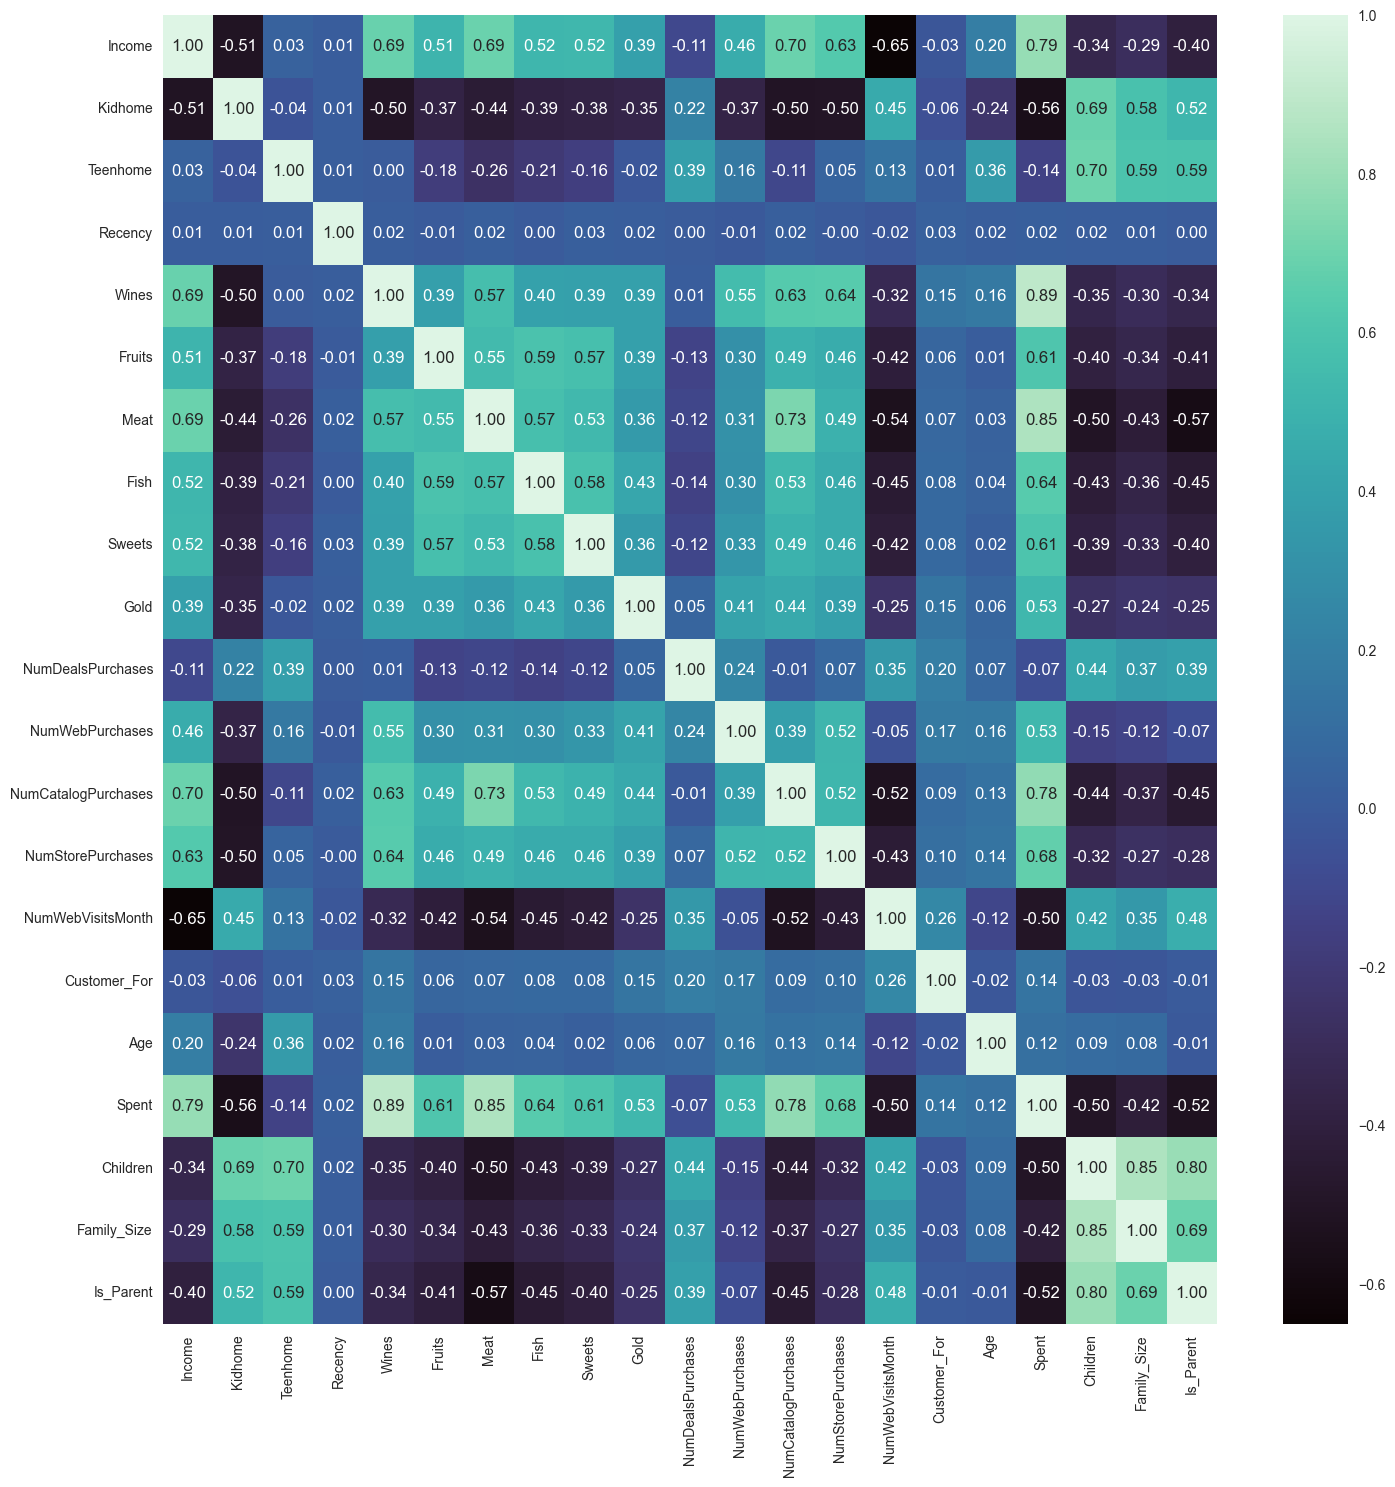

In [46]:
# Correlation matrix
plt.figure(figsize=(17,17))  
sns.heatmap(df.corr(),annot=True, fmt='0.2f', cmap='mako')

### Encoding

In [47]:
categ_cols = []

categ_cols += [col for col in df.columns if df[col].dtype == 'object']
categ_cols = np.unique(categ_cols)
print(categ_cols)

['Education' 'Living_With']


In [48]:
encoder = LabelEncoder()
for i in categ_cols:
    df[i]=df[[i]].apply(encoder.fit_transform)

In [49]:
# Creating a copy of df for profiling
df_profiling = df.copy()

### Scaling

In [50]:
scaler = StandardScaler()
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df),columns= df.columns )

In [51]:
df.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


# Dimensionality Reduction

In [52]:
# Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(df)
df = pd.DataFrame(pca.transform(df), columns=(["col1","col2", "col3"]))
df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-1.284887e-17,2.878377,-5.969394,-2.538494,-0.780421,2.383290,7.444305
col2,2212.0,6.424437e-18,1.706839,-4.312196,-1.328316,-0.158123,1.242289,6.142721
col3,2212.0,1.204582e-17,1.221956,-3.530416,-0.829067,-0.022692,0.799895,6.611222


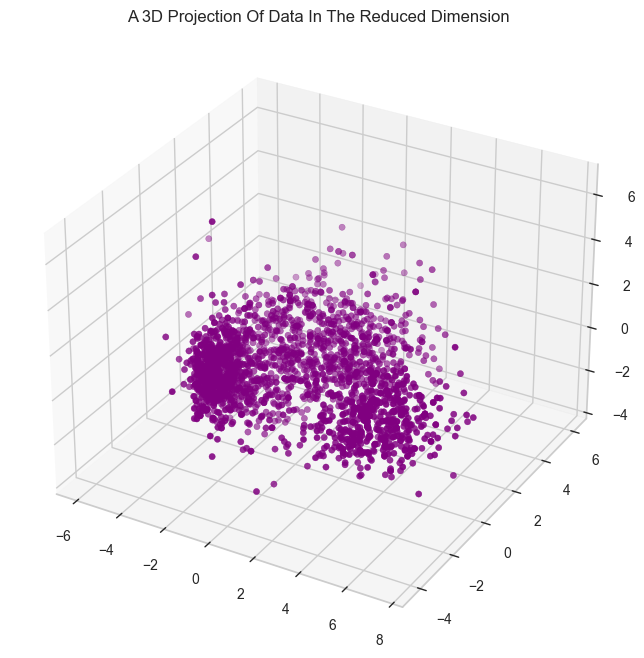

In [53]:
# 3D Projection Of Data In The Reduced Dimension
x =df["col1"]
y =df["col2"]
z =df["col3"]

#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="purple", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# Clustering

Elbow Method to determine the number of clusters to be formed:


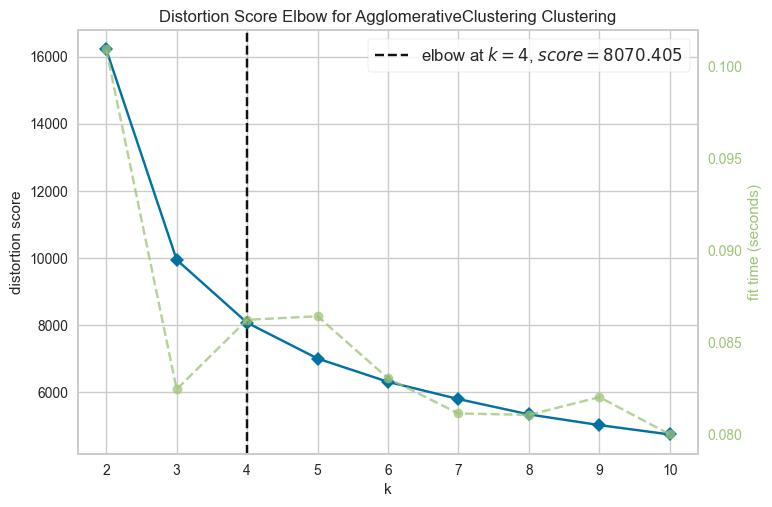

<AxesSubplot: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [54]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(AgglomerativeClustering(), k=10)
Elbow_M.fit(df)
Elbow_M.show()

In [56]:
# Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(df)
df["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
df_profiling["Clusters"]= yhat_AC

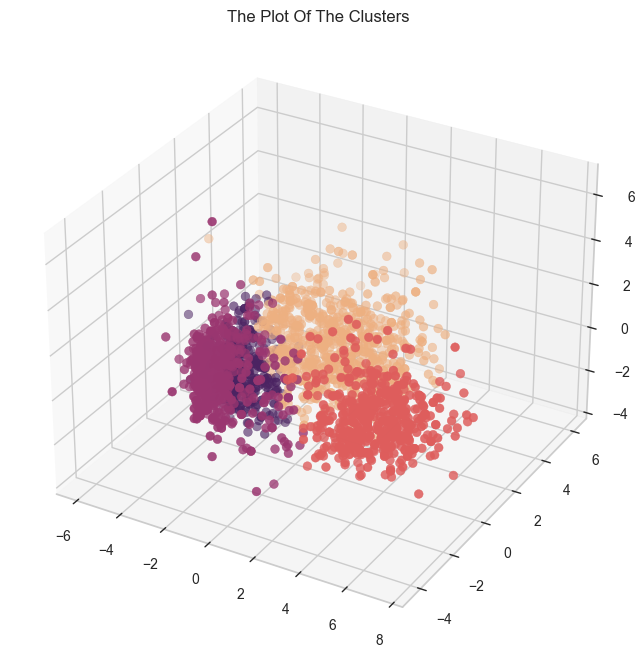

In [57]:
# Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=df["Clusters"], marker='o', cmap='flare')
ax.set_title("The Plot Of The Clusters")
plt.show()

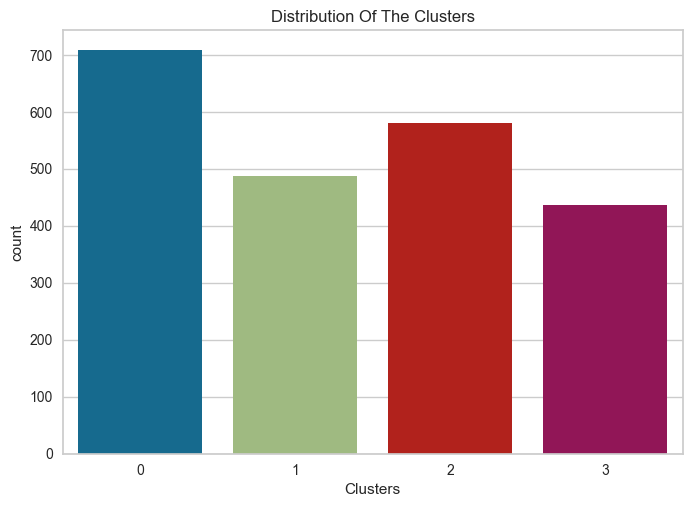

In [58]:
# Plotting countplot of clusters
sns.countplot(x=df["Clusters"])
plt.title("Distribution Of The Clusters")
plt.show()

# Profiling

### Finances - Income and Spending

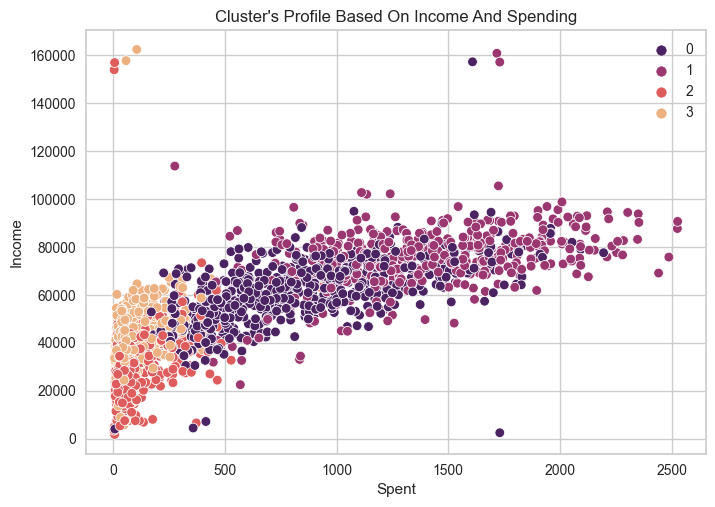

In [59]:
sns.scatterplot(data = df_profiling,x='Spent', y='Income',hue='Clusters', palette='flare_r')
plt.title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

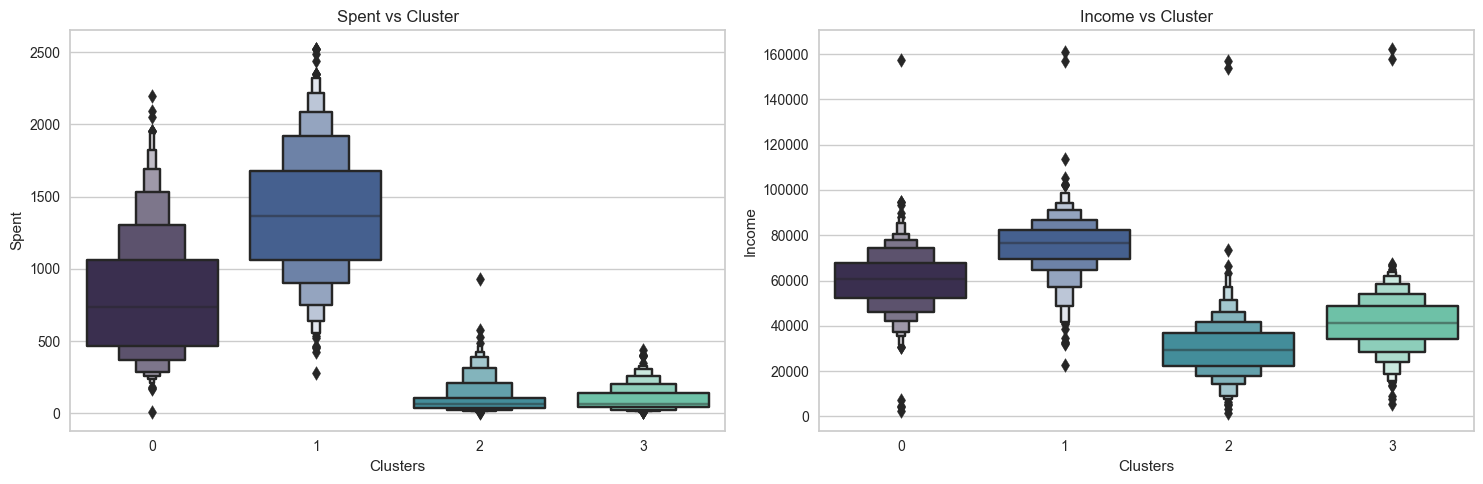

In [60]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.boxenplot(data=df_profiling, x='Clusters', y='Spent', palette='mako', ax=axes[0])
sns.boxenplot(data=df_profiling, x='Clusters', y='Income', palette='mako', ax=axes[1])
axes[0].set_title("Spent vs Cluster")
axes[1].set_title("Income vs Cluster")
plt.tight_layout()

**Income vs  spending plot shows the clusters pattern**
* Cluster 0: Average spending & Average income
* Cluster 1: High spending & High income
* Cluster 2: Low spending & Low income 
* Cluster 3: Low spending & Average income  

### Deals Purchased

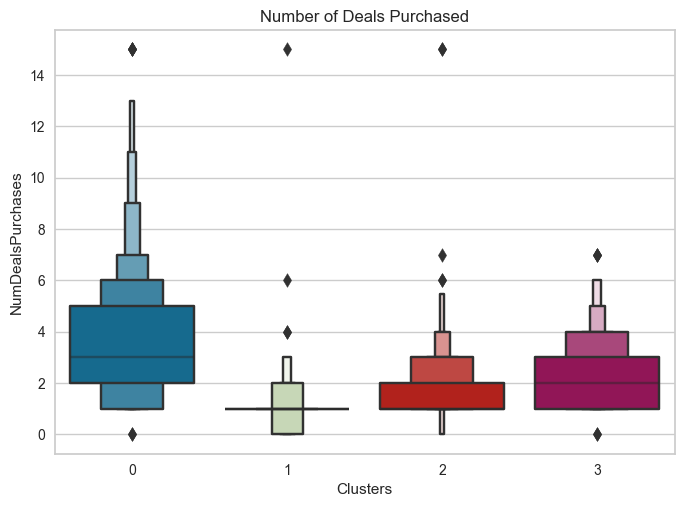

In [62]:
# Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=df_profiling["NumDealsPurchases"],x=df_profiling["Clusters"])
pl.set_title("Number of Deals Purchased")
plt.show()

### Purchases and Visits

<Figure size 800x550 with 0 Axes>

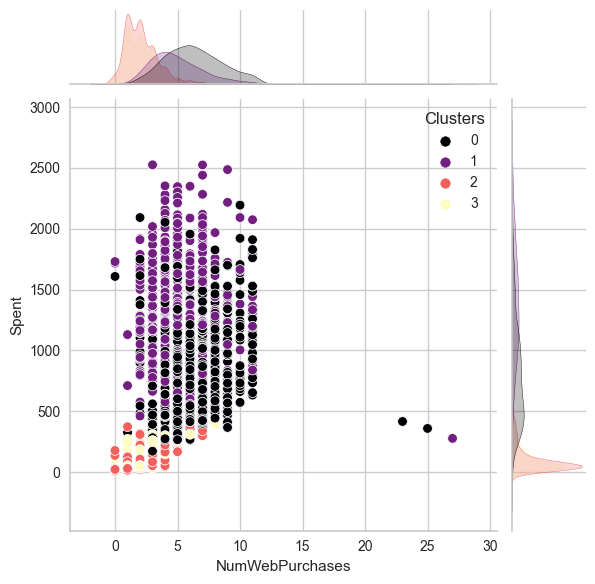

<Figure size 800x550 with 0 Axes>

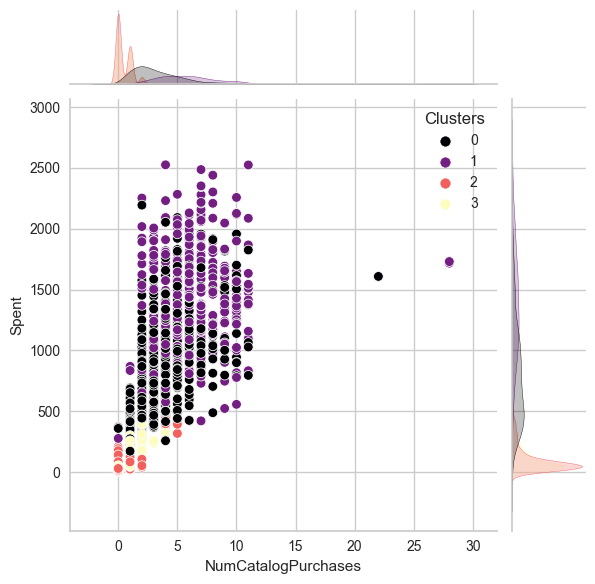

<Figure size 800x550 with 0 Axes>

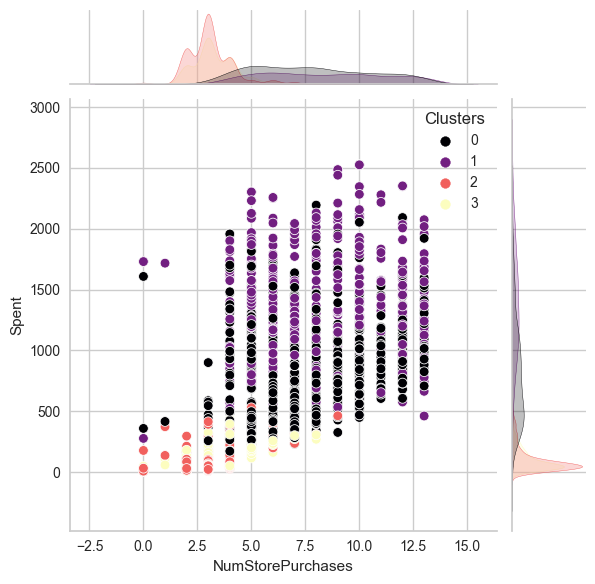

<Figure size 800x550 with 0 Axes>

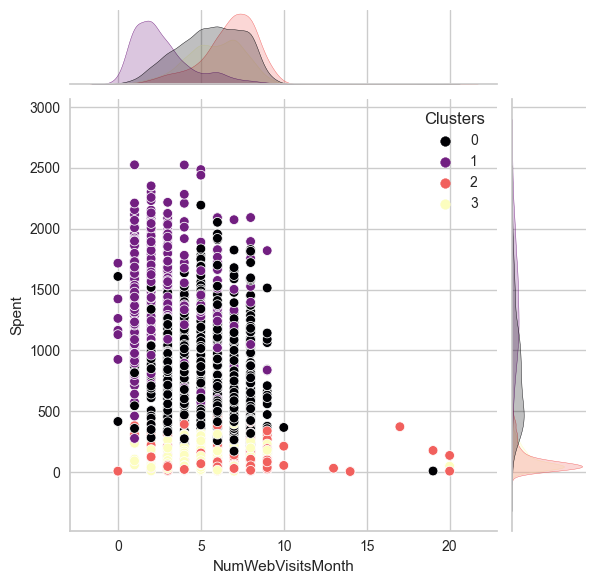

In [63]:
Places =['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',  'NumWebVisitsMonth'] 

for i in Places:
    plt.figure()
    sns.jointplot(x=i,y = 'Spent',hue='Clusters', data=df_profiling, palette= 'magma')
    plt.show()

### Personal 

<Figure size 800x550 with 0 Axes>

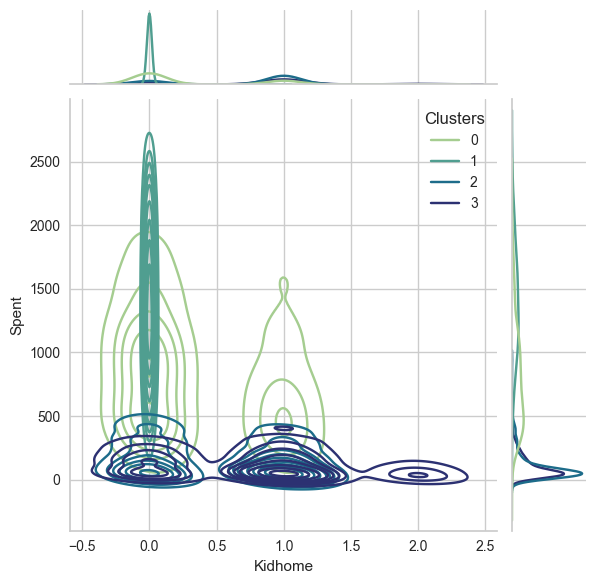

<Figure size 800x550 with 0 Axes>

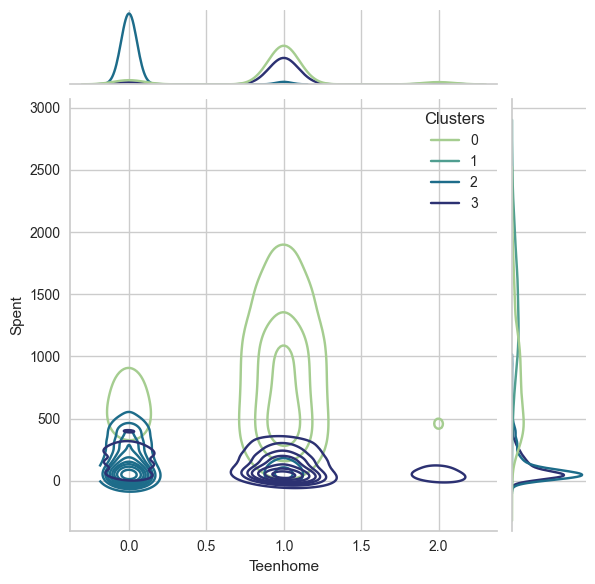

<Figure size 800x550 with 0 Axes>

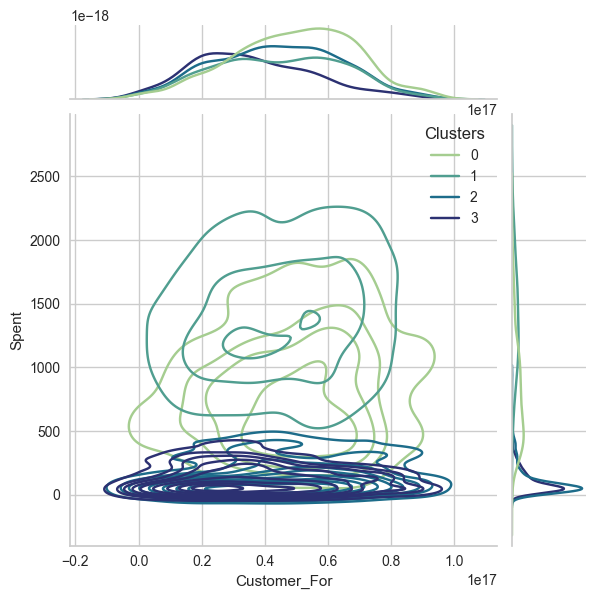

<Figure size 800x550 with 0 Axes>

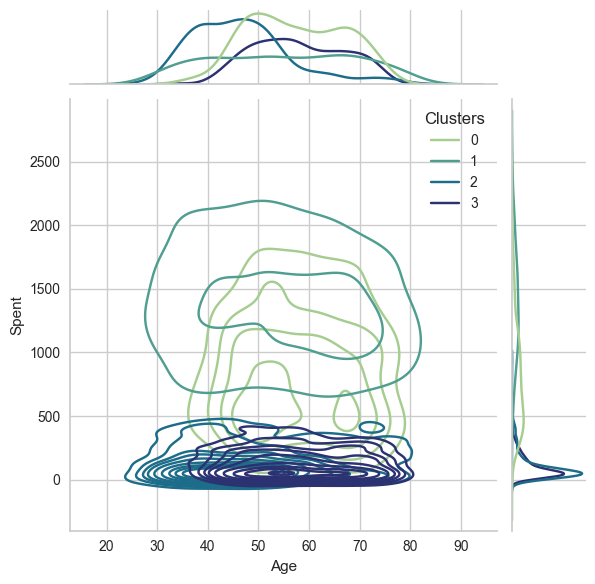

<Figure size 800x550 with 0 Axes>

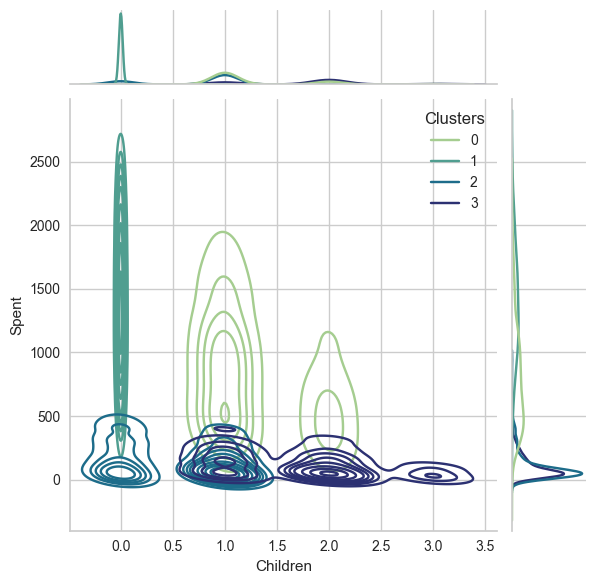

<Figure size 800x550 with 0 Axes>

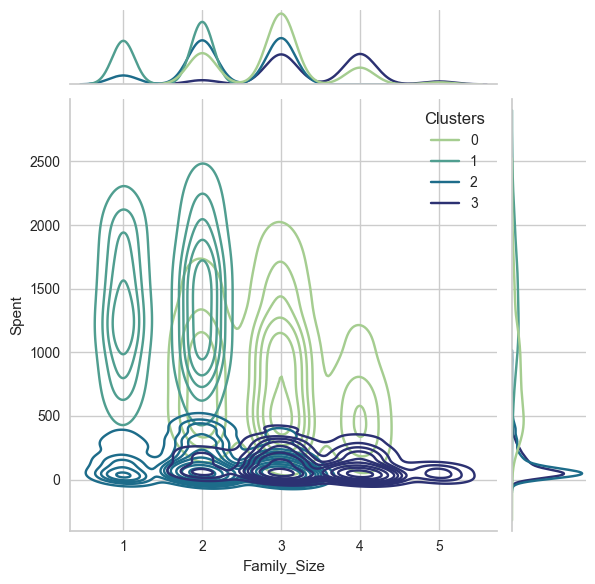

<Figure size 800x550 with 0 Axes>

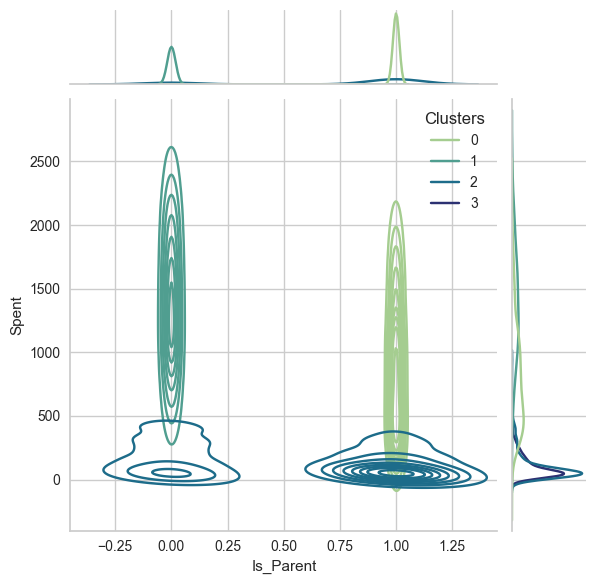

<Figure size 800x550 with 0 Axes>

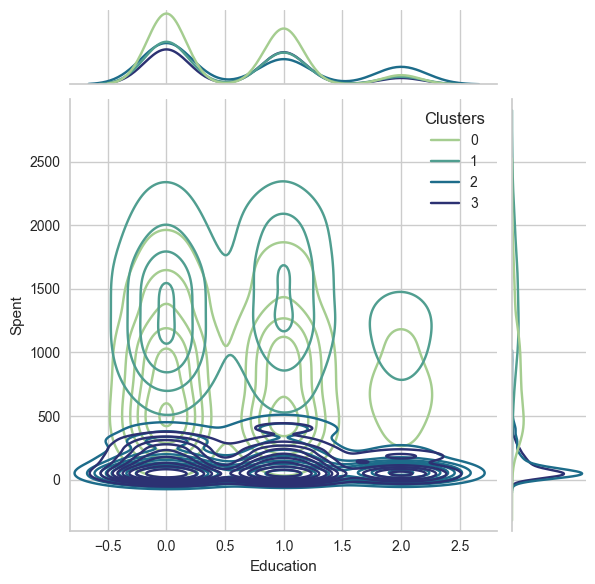

<Figure size 800x550 with 0 Axes>

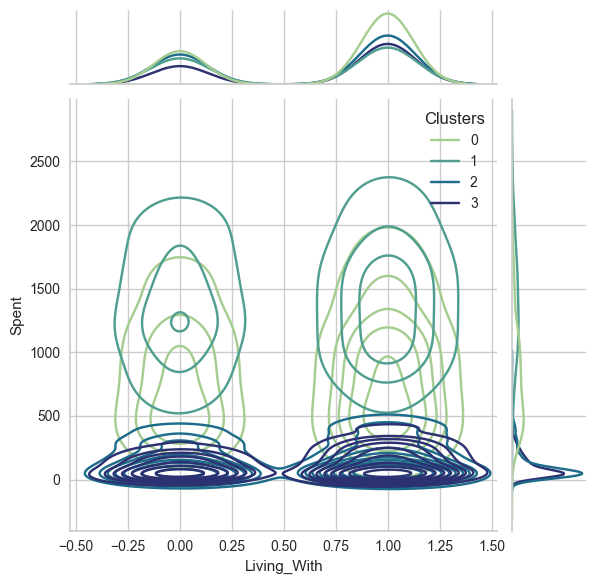

In [ ]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=i, y='Spent', hue='Clusters', data=df_profiling, kind="kde", palette='crest')
    plt.show()


# Inference

|  | Is a Parent | Members in Family | Age | Income | Relationship Status | Children
| --- | --- | --- | --- | --- | --- | --- |
| Cluster 0 | Yes | 2 to 4 | > 35 and relatively older | Average | Married | Might have a teenager |
| Cluster 1 | No | 1 or 2 | > 30 and relatively older | High | Single / Married | No kids |
| Cluster 2 | More inclined to be one | 1 to 3 | 30 to 50 | Low | Might be married | Max 1 kid |
| Cluster 3 | Yes | 2 to 5 | > 35 and relatively older | Average | Married | 1 to 3 (kids and teenager)|